In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [2]:
from multiprocessing import Pool
from tqdm import tqdm
def run_imap_multiprocessing(func, argument_list, num_processes):
    """
    Run a function in parallel using multiprocessing with a progress bar.

    Parameters:
    ----------
    func : function
        The function to be applied in parallel to each element of `argument_list`.
    
    argument_list : list
        List of arguments to be passed to `func`, each processed independently.
    
    num_processes : int
        Number of worker processes to spawn.

    Returns:
    -------
    list
        A list of results collected from applying `func` to each element in `argument_list`.

    Example:
    --------
    >>> def square(x):
    ...     return x ** 2
    >>> run_imap_multiprocessing(square, [1, 2, 3, 4], num_processes=2)
    [1, 4, 9, 16]

    Notes:
    ------
    - Uses `Pool.imap()` for memory efficiency (lazy evaluation).
    - Displays a progress bar via `tqdm` for tracking completion.
    - Ensure `if __name__ == "__main__":` when calling this in a script to prevent issues on Windows.
    """
    with Pool(processes=num_processes) as pool:
        result_list_tqdm = []
        for result in tqdm(pool.imap(func=func, iterable=argument_list), total=len(argument_list)):
            result_list_tqdm.append(result)

    return result_list_tqdm

def flatten(nested_list):
    """
    Flatten a nested list into a single list.

    Parameters:
    ----------
    nested_list : list of lists
        A list where each element is itself a list.

    Returns:
    -------
    list
        A flattened list with all elements from sublists combined.

    Example:
    --------
    >>> flatten([[1, 2], [3, 4], [5]])
    [1, 2, 3, 4, 5]
    """
    return [item for sublist in nested_list for item in sublist]

def chunks(lst, chunk_size):
    """
    Yield successive `chunk_size`-sized chunks from a list.

    Parameters:
    ----------
    lst : list
        The list to be divided into chunks.
    
    chunk_size : int
        The maximum size of each chunk.

    Yields:
    ------
    list
        A sublist of `lst` with at most `chunk_size` elements.

    Example:
    --------
    >>> list(chunks([1, 2, 3, 4, 5, 6, 7, 8], 3))
    [[1, 2, 3], [4, 5, 6], [7, 8]]
    """
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

In [3]:
import warnings
import pyBigWig
def get_mean_signal(x):
    coords, bigwig = x
    scores = []
    with warnings.catch_warnings():
        with pyBigWig.open(bigwig) as bw:
            for coord in coords:
                chrom, start, end = coord[:3]
                y = bw.values(chrom, start, end, numpy=True)
                warnings.simplefilter("ignore", category=RuntimeWarning)
                scores.append(np.nan_to_num(np.nanmean(y)))
    return(np.array(scores))

In [4]:
n_cpus = 64

In [5]:
anchors_df = pd.read_csv('/data/projects/encode/Registry/V4/GRCh38/GRCh38-Anchors.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'rDHS'])
anchors_df.head()

,chrom,start,end,rDHS
0,chr1,10033,10250,EH38D4327497
1,chr1,10385,10713,EH38D4327498
2,chr1,13251,13403,EH38D4327499
3,chr1,13904,14056,EH38D6144700
4,chr1,15168,15350,EH38D4327500


In [6]:
bigwigs = sorted(glob.glob('/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/*/*bigWig'))
bigwigs

['/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100001-GRCh38-1/MOHD_EA100001-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100002-GRCh38-1/MOHD_EA100002-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100003-GRCh38-1/MOHD_EA100003-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100004-GRCh38-1/MOHD_EA100004-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100005-GRCh38-1/MOHD_EA100005-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100006-GRCh38-1/MOHD_EA100006-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100007-GRCh38-1/MOHD_EA100007-GRCh38-1.bigWig',
 '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/macs3_signal/MOHD_EA100008-GRCh38-1/MOHD_EA100008-GRCh38-1.bigWig',


In [7]:
coords = list(zip(anchors_df.chrom, anchors_df.start, anchors_df.end))

In [8]:
X = np.zeros([anchors_df.shape[0], len(bigwigs)])
X.shape

(2950228, 50)

In [9]:
for i, bigwig in enumerate(bigwigs):
    X[:,i] = np.concatenate(run_imap_multiprocessing(get_mean_signal, [[_, bigwig] for _ in chunks(coords, 100)], n_cpus))

100%|██████████| 29503/29503 [00:04<00:00, 6487.49it/s]


1708597

In [10]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(np.log2(X + .01))

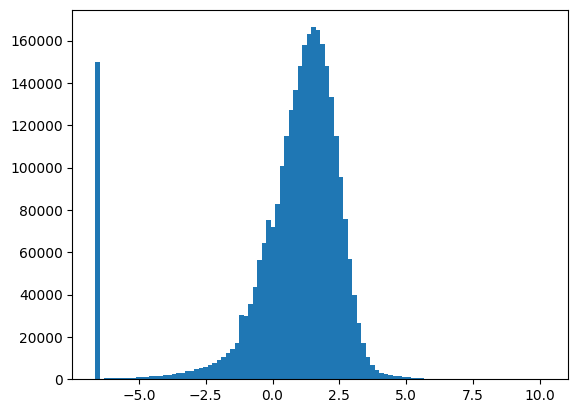

In [14]:
fig, ax = plt.subplots()
_ = ax.hist(np.log2(X[:,0]+.01), 100)

(2950228, 50)

In [37]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=2).fit_transform(np.transpose(X_scaled))
X_scaled = np.log2(X[~np.all(X == 0, axis=1)] + .01)

pca = PCA(n_components=2).fit_transform(np.transpose(X_scaled))

In [38]:
X_scaled.shape

(2950189, 50)

In [42]:
X.shape

(2950228, 50)

In [43]:
# df = pd.DataFrame({'bigwig' : bigwigs})
# df['sample'] = df.bigwig.apply(lambda  x: os.path.basename(x).replace('.bigWig', ''))
df = pd.read_csv('../atac-metadata.txt', sep='\t', header=None, names=['sample', 'id'])
df[['PC_1', 'PC_2']] = pca
df['center'] = df['sample'].apply(lambda  x: x.split('_')[0])
df['protocol'] = df['sample'].apply(lambda  x: x.split('_')[2])

In [44]:
df

,sample,id,PC_1,PC_2,center,protocol
0,CCH_0001_BC_01,MOHD_EA100001,-157.987984,-127.599645,CCH,BC
1,CCH_0002_BC_01,MOHD_EA100002,515.721632,-355.824972,CCH,BC
2,CCH_0003_BC_01,MOHD_EA100003,129.864097,-357.653133,CCH,BC
3,CKD_0001_BC_01,MOHD_EA100004,539.974097,-299.541474,CKD,BC
4,CKD_0001_PC_01,MOHD_EA100005,842.325199,174.199868,CKD,PC
5,CKD_0001_PO_01,MOHD_EA100006,-778.310834,-173.151686,CKD,PO
6,CKD_0002_BC_01,MOHD_EA100007,182.596627,-48.680628,CKD,BC
7,CKD_0002_PC_01,MOHD_EA100008,1064.530318,382.030439,CKD,PC
8,CKD_0002_PO_01,MOHD_EA100009,-1056.480106,-72.238873,CKD,PO
9,CKD_0003_BC_01,MOHD_EA100010,125.883751,-316.437237,CKD,BC


In [56]:
def get_tss(sample_id):
    tss_dir = '/zata/zippy/andrewsg/projects/mohd/atac/results-072225/qc/tss_enrichment/'
    tss_file = os.path.join(tss_dir, f'{sample_id}-GRCh38-1.txt')
    with open(tss_file) as f:
        return(float(f.readline().strip().split()[-1]))

In [58]:
df['tss_enrichment'] = df.id.apply(get_tss)

In [59]:
df

,sample,id,PC_1,PC_2,center,protocol,tss_enrichment
0,CCH_0001_BC_01,MOHD_EA100001,-157.987984,-127.599645,CCH,BC,8.47
1,CCH_0002_BC_01,MOHD_EA100002,515.721632,-355.824972,CCH,BC,6.50
2,CCH_0003_BC_01,MOHD_EA100003,129.864097,-357.653133,CCH,BC,4.62
3,CKD_0001_BC_01,MOHD_EA100004,539.974097,-299.541474,CKD,BC,5.27
4,CKD_0001_PC_01,MOHD_EA100005,842.325199,174.199868,CKD,PC,16.50
5,CKD_0001_PO_01,MOHD_EA100006,-778.310834,-173.151686,CKD,PO,7.62
6,CKD_0002_BC_01,MOHD_EA100007,182.596627,-48.680628,CKD,BC,7.57
7,CKD_0002_PC_01,MOHD_EA100008,1064.530318,382.030439,CKD,PC,23.22
8,CKD_0002_PO_01,MOHD_EA100009,-1056.480106,-72.238873,CKD,PO,5.75
9,CKD_0003_BC_01,MOHD_EA100010,125.883751,-316.437237,CKD,BC,6.32


In [69]:
X_scaled.shape[0]

2950189

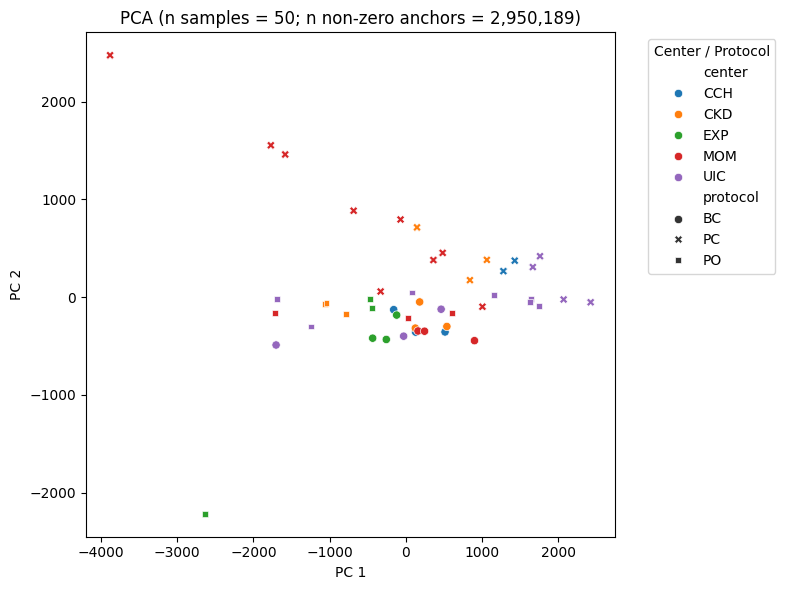

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 6))  # you can adjust the figsize as needed

# Plot the seaborn scatterplot on the axis
sns.scatterplot(data=df, x='PC_1', y='PC_2', hue='center', style='protocol', ax=ax)

# Customize as desired
ax.set_title(f"PCA (n samples = {len(df)}; n non-zero anchors = {X_scaled.shape[0]:,})")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend(title="Center / Protocol", bbox_to_anchor=(1.05, 1), loc='upper left')  # moves legend outside

plt.tight_layout()
plt.show()


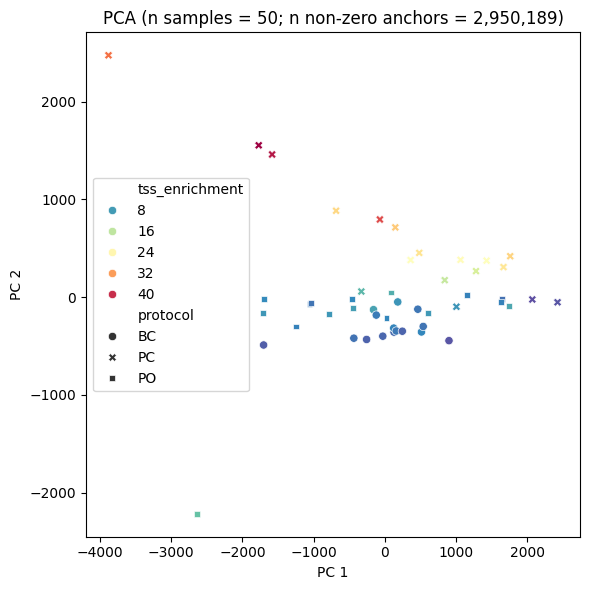

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot with custom colormap
sns.scatterplot(
    data=df,
    x='PC_1',
    y='PC_2',
    hue='tss_enrichment',
    palette='Spectral_r',  # apply Spectral colormap
    style='protocol',
    ax=ax
)

# Customize axes
ax.set_title(f"PCA (n samples = {len(df)}; n non-zero anchors = {X_scaled.shape[0]:,})")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

plt.tight_layout()
plt.show()


In [77]:
df.sort_values('tss_enrichment', ascending=False)

,sample,id,PC_1,PC_2,center,protocol,tss_enrichment
38,MOM_003_PC_02,MOHD_EA100039,-1770.428742,1554.282578,MOM,PC,43.15
26,MOM_0003_PC_01,MOHD_EA100027,-1582.480275,1460.459712,MOM,PC,41.54
41,MOM_009_PC_01,MOHD_EA100042,-68.267194,795.175405,MOM,PC,37.81
37,MOM_002_PC_02,MOHD_EA100038,-3880.756816,2475.794216,MOM,PC,34.81
10,CKD_0003_PC_01,MOHD_EA100011,147.811240,714.305711,CKD,PC,28.54
48,UIC_0029_PC_01,MOHD_EA100049,1762.321738,419.361230,UIC,PC,27.76
23,MOM_0002_PC_01,MOHD_EA100024,-683.811111,884.782821,MOM,PC,27.47
40,MOM_008_PC_01,MOHD_EA100041,484.655808,453.383869,MOM,PC,26.44
42,UIC_0015_PC_01,MOHD_EA100043,1667.826481,308.126344,UIC,PC,25.95
7,CKD_0002_PC_01,MOHD_EA100008,1064.530318,382.030439,CKD,PC,23.22


In [47]:
import umap
u = umap.UMAP().fit_transform(np.transpose(X_scaled))

ModuleNotFoundError: No module named 'umap'

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

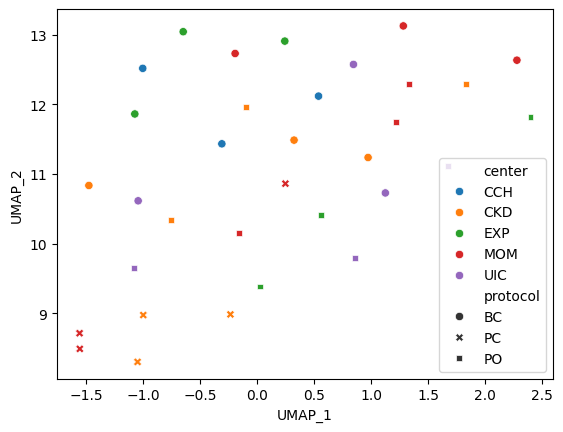

In [83]:
df[['UMAP_1', 'UMAP_2']] = u
sns.scatterplot(data=df, x='UMAP_1', y='UMAP_2', hue='center', style='protocol')